In [ ]:
import os
import gc
import sys
from IPython.display import Markdown

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_curve, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback
)

# CVEFixes.csv

Данные - набор исходных кодов на разных языках программирования с метками уязвимости ("vulnerable"/"safe").

Задача - бинарная классификация по метке уязвимости.

In [2]:
kaggle_inp = "/kaggle/input/cvefixes/"
kaggle_out = "/kaggle/working/"
os.makedirs("/kaggle/working/cache", exist_ok=True)

In [18]:
cached_df_path = kaggle_out + "cache/cve.pkl"
if os.path.exists(cached_df_path):
    df_raw = pd.read_pickle(cached_df_path)
else:
    df_raw = pd.read_csv(kaggle_inp + 'cvefixes/CVEFixes.csv')
    df_raw.to_pickle(cached_df_path)

print(f"df_raw.shape = {df_raw.shape}")
df_raw.head(5)

df_raw.shape = (31194, 3)


,code,language,safety
0,package org.bouncycastle.jcajce.provider.asymm...,java,vulnerable
1,<?php\n\n\n\n/**\n\n * ownCloud - user_ldap\n\...,php,vulnerable
2,#!/usr/bin/env python\n\nfrom __future__ impor...,py,safe
3,/* -*- c-basic-offset: 8 -*-\n\n rdesktop: A...,c,safe
4,<!DOCTYPE html>\n\n<html>\n\n <head>\n\n ...,html,safe


In [19]:
df_raw[df_raw["language"] == "c"].shape

(8632, 3)

In [ ]:
df = df_raw[(df_raw['language'] != 'Other') & (df_raw['code'] != '404: Not Found')].iloc[:8000,:].dropna(subset=["code", "safety"]).drop_duplicates(subset="code")
# df = df_raw[(df_raw['language'] == 'c') & (~df_raw['code'].isin(['404: Not Found', '400: Invalid request']))].dropna(subset=["code", "safety"]).drop_duplicates(subset="code")

In [40]:
df.shape

(6706, 3)

In [8]:
df_raw = None

### Примеры кодов в датасете

In [53]:
code, lang, saf = df[(df["safety"] == "safe") & (df["code"].str.len() < 400)].head(1).iloc[0]
print(f"{80 * '-'}\nLanguage: {lang}, {saf}")
display(Markdown(f"```{lang}\n{code}\n```"))
code, lang, saf = df[(df["safety"] != "safe") & (df["code"].str.len() < 900)].head(1).iloc[0]
print(f"{80 * '-'}\nLanguage: {lang}, {saf}")
display(Markdown(f"```{lang}\n{code}\n```"))

--------------------------------------------------------------------------------
Language: c, safe


```c
#include "clar_libgit2.h"



#include "delta.h"



void test_delta_apply__read_at_off(void)

{

	unsigned char base[16] = { 0 }, delta[] = { 0x10, 0x10, 0xff, 0xff, 0xff, 0xff, 0xff, 0x10, 0x00, 0x00 };

	void *out;

	size_t outlen;



	cl_git_fail(git_delta_apply(&out, &outlen, base, sizeof(base), delta, sizeof(delta)));

}

```

--------------------------------------------------------------------------------
Language: c, vulnerable


```c
/*

 * Name: strstr and strdup

 *

 * These are the standard library utilities.  We define them here for

 * systems that don't have them.

 */



#ifndef HAVE_STRSTR

char *strstr(char *s1, char *s2)

{                               /* from libiberty */

    char *p;

    int len = strlen(s2);



    if (*s2 == '\0')            /* everything matches empty string */

        return s1;

    for (p = s1; (p = strchr(p, *s2)) != NULL; p = strchr(p + 1, *s2)) {

        if (strncmp(p, s2, len) == 0)

            return (p);

    }

    return NULL;

}

#endif



#ifndef HAVE_STRDUP

char *strdup(char *s)

{

    char *retval;



    retval = (char *) malloc(strlen(s) + 1);

    if (retval == NULL) {

        perror("boa: out of memory in strdup");

        exit(1);

    }

    return strcpy(retval, s);

}

#endif

```

Классы распределены одинаково:

In [54]:
print(f'df.shape: {df.shape}\nSafe codes: {df[df.safety == "safe"].shape[0]} ({df[df.safety == "safe"].shape[0] / df.shape[0] * 100:.2f}%)')

df.shape: (6706, 3)
Safe codes: 3416 (50.94%)


### Добавим информацию о языках в колонку `code` в виде особых токенов

In [ ]:
lang_tokens = list(map(lambda x: f"[{x}]", df['language'].str.upper().unique()))
print(f"Language Tokens: {', '.join(lang_tokens)}")

In [ ]:
df["code"] = df["language"].map(lambda x: f"[{x.upper()}]") + df["code"]
df["code"].head()

### Разделим на train, val, test

<!-- Будем использовать только код, без языка -->

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df["code"], df["safety"], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Токенайзер

In [73]:
os.remove(tokenizer_cache_path)

In [74]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()
token_trainer = BpeTrainer(
    # special_tokens=["[UNK]"] + lang_tokens,
    special_tokens=["[UNK]"],
    show_progress=True,
    min_frequency=10,
    vocab_size=5000
)
tokenizer_cache_path = kaggle_out + "cache/tokenizer.json"
if not os.path.exists(tokenizer_cache_path):
    train_txt_cache_path = kaggle_out + "cache/train.txt"
    if not os.path.exists(train_txt_cache_path):
        print(f'[INFO]: saving train data to "{train_txt_cache_path}"')
        X_train.to_csv(train_txt_cache_path, header=False, index=False)
    print("[INFO]: training the tokenizer")

    tokenizer.train([train_txt_cache_path], token_trainer)
    print(f"[INFO]: saving the tokenizer to {tokenizer_cache_path}")
    tokenizer.save(tokenizer_cache_path)
else:
    tokenizer = Tokenizer.from_file(tokenizer_cache_path)

[INFO]: training the tokenizer



[INFO]: saving the tokenizer to /kaggle/working/cache/tokenizer.json


### Проверка адекватности токенайзера

In [75]:
test_encode = tokenizer.encode_batch(df.code[df.code.str.len() < 500].iloc[[0]])
print(test_encode[0].ids)
print(test_encode[0].tokens)

[6, 484, 5, 317, 3790, 2232, 4621, 21, 17, 75, 5, 6, 484, 5, 2476, 17, 75, 5, 316, 2639, 2476, 66, 447, 923, 351, 66, 670, 1744, 380, 11, 316, 12, 94, 401, 309, 685, 62, 437, 64, 32, 94, 19, 363, 2476, 1788, 32, 94, 3648, 15, 3648, 15, 1494, 15, 1494, 15, 1494, 15, 1494, 15, 1494, 15, 3648, 15, 622, 15, 622, 841, 316, 13, 376, 30, 528, 376, 241, 30, 317, 66, 4621, 462, 1082, 11, 4622, 2476, 66, 1309, 430, 314, 376, 15, 9, 376, 241, 15, 685, 15, 423, 11, 685, 377, 2476, 15, 423, 11, 2476, 1995, 96]
['#', 'include', '"', 'cl', 'ar_', 'lib', 'git', '2', '.', 'h', '"', '#', 'include', '"', 'delta', '.', 'h', '"', 'void', 'test_', 'delta', '_', 'ap', 'pl', 'y_', '_', 'read_', 'at_', 'off', '(', 'void', ')', '{', 'unsigned', 'char', 'base', '[', '16', ']', '=', '{', '0', '},', 'delta', '[]', '=', '{', '0x10', ',', '0x10', ',', '0xff', ',', '0xff', ',', '0xff', ',', '0xff', ',', '0xff', ',', '0x10', ',', '0x00', ',', '0x00', '};', 'void', '*', 'out', ';', 'size_t', 'out', 'len', ';', 'cl', '_

## Создаём Dataset класс для Torch

In [ ]:
MAX_LEN = 10000

In [78]:
class CVEDataset(Dataset):
    def __init__(self, code: pd.Series, safety: pd.Series, device=torch.device("cpu")):
        self.target = torch.tensor(
            safety.map({"vulnerable": 1.0, "safe": 0.0}).values,
            dtype=torch.float,
            device=device,
        )
        self.device = device
        self.code = code
        # self.empty_data = None
        n = len(safety)
        data = np.zeros((n, MAX_LEN))
        tokenized = tokenizer.encode_batch_fast(code)
        for idx, seq in enumerate(tokenized):
            out_len = min(len(seq.ids), MAX_LEN)
            data[idx, :out_len] = seq.ids[:out_len]

        self.data = torch.tensor(data, dtype=torch.long, device=device)

    def __len__(self) -> int:
        return self.code.shape[0]

    def __getitem__(self, idx):
        # tokenized = tokenizer.encode_batch_fast(list(self.code.iloc[idx]) if len(idx) <= 1 else self.code.iloc[idx])
        # if self.empty_data is None:
        #     self.empty_data = np.zeros((len(tokenized), MAX_LEN))
        
        # for i, seq in enumerate(tokenized):
            # out_len = min(len(seq.ids), MAX_LEN)
            # self.empty_data[i, :out_len] = seq.ids[:out_len]
        # return torch.tensor(self.empty_data, dtype=torch.long, device=self.device), self.target[idx]
        return self.data[idx], self.target[idx]

## Класс архитектуры нейронной сети

In [79]:
class CVEClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout_p=0.1, bidirectional=True, gru_layers=1, device=torch.device("cpu")):
        super(CVEClassifier, self).__init__()
        self.device = device
        self.embedding = nn.Embedding(vocab_size, embedding_dim, device=device)
        self.norm = nn.BatchNorm1d(MAX_LEN, device=device)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=gru_layers, bidirectional=bidirectional, batch_first=True, device=device)
        self.dropout = nn.Dropout(dropout_p)
        self.act_out = nn.Sigmoid()
        # self.act = nn.LeakyReLU()
        # self.fc = nn.Linear(hidden_size, hidden_size, device=device)
        self.fc_out = nn.Linear(hidden_size * (1 + bidirectional), 1, device=device)
        
    def forward(self, x):
        x_dev = x.to(self.device)

        embedded = self.dropout(self.norm(self.embedding(x_dev)))
        if embedded.isnan().any():
            print(embedded)
            raise AssertionError
        output = self.gru(embedded)[0][:, -1, :]
        if output.isnan().any():
            print(output)
            raise AssertionError
        # output = self.act(self.fc(output))
        # output = self.act_out(self.fc_out(output))
        output = self.fc_out(output)
        if output.isnan().any():
            print(output)
            raise AssertionError
        return output

### Циклы обучения и тестирования

In [80]:
def train_loop(dataloader, model, loss_fn, optimizer, device=torch.device("cpu")):
    model.train()
    train_loss = 0.0
    for inputs, y in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        # assert all((outputs >= 0) & (outputs <= 1))
        loss = loss_fn(outputs.view(-1), y.to(device).view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss

    return train_loss * dataloader.batch_size / len(dataloader.dataset)

def test_loop(
    dataloader,
    model,
    loss_fn,
    device=torch.device("cpu")
):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, y in dataloader:
            outputs = model(inputs.to(device))
            # assert all((outputs >= 0) & (outputs <= 1))
            loss = loss_fn(outputs.view(-1), y.to(device).view(-1))
            test_loss += loss

    return test_loss * dataloader.batch_size / len(dataloader.dataset)

In [81]:
embedding_dim = 160
hidden_size = 160
batch_size = 32
learning_rate = 0.001
device_storage = torch.device("cpu")
# device_storage = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device_train = torch.device("cpu")
device_train = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CVEClassifier(vocab_size, embedding_dim, hidden_size, device=device_train)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print(f"Количество параметров модели: {sum([len(p) for p in model.parameters()])}")

Количество параметров модели: 28842


In [82]:
print("[INFO]: Creating Training Dataset")
train_dataset = CVEDataset(X_train, y_train, device=device_storage)
print("[INFO]: Creating Validation Dataset")
val_dataset = CVEDataset(X_val, y_val, device=device_storage)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

[INFO]: Creating Training Dataset
[INFO]: Creating Validation Dataset


In [83]:
num_epochs = 0
num_epochs_step = 10
train_loss = []
val_loss = []

In [84]:
num_epochs += num_epochs_step
for epoch in range(num_epochs):
    train_loss.append(train_loop(train_loader, model, loss_fn, optimizer, device_train))
    val_loss.append(test_loop(val_loader, model, loss_fn, device_train))
    print(f"Epoch {len(train_loss)}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}")
    if len(val_loss) >= 4 and (val_loss[-1] > val_loss[-2] > val_loss[-3] > val_loss[-4]):
        print("Stopped the training because last values of validation loss were increasing")
        break

Epoch 1/10, Train Loss: 0.7109, Val Loss: 0.7087
Epoch 2/10, Train Loss: 0.6966, Val Loss: 0.7185
Epoch 3/10, Train Loss: 0.6861, Val Loss: 0.7456
Epoch 4/10, Train Loss: 0.6727, Val Loss: 0.7669
Stopped the training because last values of validation loss were increasing


## Метрики на тестовой выборке

### Точность:

In [85]:
test_dataset = CVEDataset(X_test, y_test, device=device_storage)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_pred = np.array([])
test_true = np.array([])
with torch.no_grad():
    for inp, y in test_loader:
        test_true = np.concatenate([test_true, y.view(-1).cpu().numpy()])
        test_pred = np.concatenate([test_pred, model(inp).view(-1).cpu().numpy()])

In [116]:
test_pred_01 = 1/(1 + np.exp(-test_pred))
test_pred_labels = np.round(test_pred_01)
print(f"Accuracy Score: {accuracy_score(test_true, test_pred_labels):.4f}")

Accuracy Score: 0.4791


### Confusion Matrix

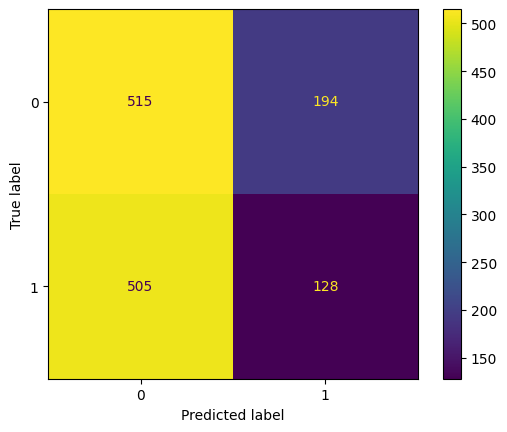

In [118]:
cm = confusion_matrix(test_true, test_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot();

### ROC-кривая:

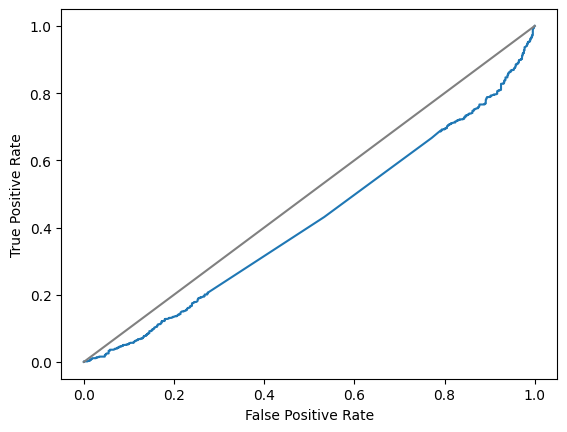

In [119]:
fpr, tpr, _ = roc_curve(test_true, test_pred_01)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.plot([0, 1], [0, 1], color="gray");

Получается надо предсказывать ровно наоборот

### PR-кривая

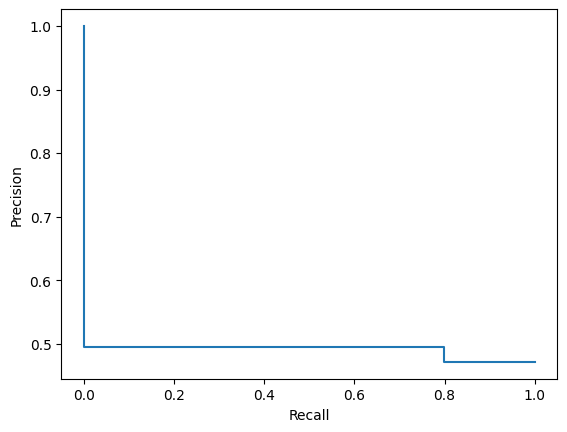

In [123]:
precision, recall, _ = precision_recall_curve(test_true, 1 - test_pred_labels)
disp = PrecisionRecallDisplay(precision=precision, recall=recall).plot();

В такой задаче, конечно, важнее Recall (чтобы отлавливать как можно больше уязвимого кода до того, как он на что-то повлияет). 

### Пример с трансформером

In [5]:
model_name = "microsoft/codebert-base"

tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2   # safety: 0/1
)

print(model)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [27]:
def tokenize_function(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=64
    )

X_train_tokenized = tokenize_function(X_train)
X_val_tokenized = tokenize_function(X_val)
X_test_tokenized = tokenize_function(X_test)

In [32]:
class CodeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = CodeDataset(X_train_tokenized, y_train)
val_dataset = CodeDataset(X_val_tokenized, y_val)
test_dataset = CodeDataset(X_test_tokenized, y_test)

In [11]:
def compute_metrics(p):
    preds, labels = p
    if isinstance(preds, tuple):
        preds = preds[0]
    
    preds_class = np.argmax(preds, axis=1)
    
    probabilities = torch.nn.functional.softmax(torch.tensor(preds), dim=1).numpy()
    
    accuracy = accuracy_score(labels, preds_class)
    precision = precision_score(labels, preds_class, zero_division=0)
    recall = recall_score(labels, preds_class, zero_division=0)
    f1 = f1_score(labels, preds_class, zero_division=0)
    
    if len(np.unique(labels)) > 1:
        roc_auc = roc_auc_score(labels, probabilities[:, 1])
    else:
        roc_auc = 0.0
    
    return {
        "accuracy": accuracy,
        "precision": precision, 
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    }

In [43]:
training_args = TrainingArguments(
    output_dir="./output",
    num_train_epochs=3, 
    per_device_train_batch_size=8,     
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=50, 
    logging_steps=50,
    eval_strategy="steps",  
    eval_steps=300,         
    save_strategy="no",     
    fp16=False,            
    dataloader_pin_memory=False,
    dataloader_num_workers=0,
    report_to=None,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [45]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
300,0.700400,0.693208,0.509786,0.000000,0.000000,0.000000,0.507115
600,0.699300,0.693923,0.488350,0.298246,0.032319,0.058319,0.459949
900,0.695800,0.694364,0.509786,0.000000,0.000000,0.000000,0.445736
1200,0.695300,0.694363,0.480895,0.480503,0.726236,0.578350,0.473356
1500,0.696000,0.695199,0.475303,0.473071,0.617871,0.535862,0.452756


TrainOutput(global_step=1611, training_loss=0.6972352462403897, metrics={'train_runtime': 2423.8277, 'train_samples_per_second': 5.311, 'train_steps_per_second': 0.665, 'total_flos': 423378576956160.0, 'train_loss': 0.6972352462403897, 'epoch': 3.0})

In [47]:
trainer.evaluate()

{'eval_loss': 0.69501131772995,
 'eval_accuracy': 0.4874184529356943,
 'eval_precision': 0.38,
 'eval_recall': 0.07224334600760456,
 'eval_f1': 0.12140575079872204,
 'eval_roc_auc': 0.4483233815975143,
 'eval_runtime': 40.9534,
 'eval_samples_per_second': 26.2,
 'eval_steps_per_second': 1.66,
 'epoch': 3.0}